In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [3]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '1', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/synthetic/instances.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 50, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
flags.DEFINE_float('lr', 0.1, 'lr')
flags.DEFINE_float('reg', 1., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 256, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 32, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 256, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 512, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 512, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 32, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [5]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [6]:
def get_batches(instances, batch_size, iterator=False):
    iter_instances = iter(instances)
    n_batch = len(instances)//batch_size
    
    batches = [(i_batch, [next(iter_instances) for i_doc in range(batch_size)]) for i_batch in range(n_batch)]
    
    if iterator: batches = iter(batches)
    return batches

train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_batches(instances_test, config.batch_size)

In [7]:
flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [8]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    
    

# run model 

## init

In [9]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [10]:
tf.reset_default_graph()

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2], 
#              1:[10, 11], 2:[20, 21, 22], 
#              10: [100, 101], 11: [110, 111, 112], 20: [200, 201], 21: [210, 211], 22:[220, 221, 222]
#              }

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}


# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

## doubly rnn

In [11]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [12]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs

## stick break

In [13]:
def hierarchical_sbp(tree_sticks_topic, tree_sticks_branch):
    tree_prob_topic = {}
    rest_topics = {}

    # calculate topic probability and save
    stick_topic = tree_sticks_topic[0]
    tree_prob_topic[0] = stick_topic
    rest_topics[0] = 1.-stick_topic
    for parent_idx, child_idxs in tree_idxs.items():
        rest_topic = rest_topics[parent_idx]
        rest_branch = 1.
        for child_idx in child_idxs:
            # calculate topic probability
            if child_idx == child_idxs[-1]: # last child
                prob_branch = rest_branch # phi
            else:
                stick_branch = tree_sticks_branch[child_idx] # psi
                prob_branch = stick_branch * rest_branch # phi

            if not child_idx in tree_idxs: # leaf childs
                prob_topic = prob_branch * rest_topic # pi
            else:
                stick_topic = tree_sticks_topic[child_idx] # upsilon
                prob_topic = stick_topic * prob_branch * rest_topic # pi

            # save topic probability and update rest stick length
            tree_prob_topic[child_idx] = prob_topic
            rest_branch = (1.- stick_branch) * rest_branch
            rest_topics[child_idx] = (1.-stick_topic)*prob_branch * rest_topic
            
    return tree_prob_topic

## build model

In [14]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.relu, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_sticks_branch = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_branch')

    tree_prob_topic = hierarchical_sbp(tree_sticks_topic, tree_sticks_branch)
    prob_topic = tf.concat(list(tree_prob_topic.values()), 1)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
    tree_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, name='emb_topic')
    topic_embeddings = tf.concat(list(tree_topic_embeddings.values()), 0)
    
    topic_bow = tf.nn.softmax(tf.matmul(topic_embeddings, bow_embeddings, transpose_b=True), 1) # bow vectors for each topic
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [15]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [16]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg)


global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 10, name='topic_freq_bow').indices

In [17]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [25]:
from matplotlib.colors import Normalize # Normalizeをimport

def print_topic_sample():
    _topics_bow = sess.run(topic_bow)
    plt.figure(figsize=(3, 4))
    
    _topic_bow = _topics_bow[0]
    plt.subplot(5,3,2)
    plt.axis('off')
    plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(_topics_bow)))
    
    for i in range(1, len(topic_idxs)):
        _topic_bow = _topics_bow[i]
        plt.subplot(5,3,i+3)
        plt.axis('off')
        plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(_topics_bow)))
        
    plt.show()

In [26]:
if 'sess' in globals(): sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

TRAIN:   TM                      VALID:   TM                 \
     Time Ep Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL     KL   
1       1  0  0  683.97  901  680.38  2.92  0.67  693.55  907  680.98  11.93   
157     2  1  0  679.75  891  679.20  0.16  0.38  679.09  887  678.75   0.01   
313     2  2  0  679.33  888  678.92  0.08  0.33  679.08  886  678.73   0.00   
469     2  3  0  679.11  887  678.77  0.06  0.29  679.10  887  678.82   0.00   
625     2  4  0  678.98  886  678.67  0.04  0.27  679.18  888  678.92   0.00   
781     2  5  0  678.88  885  678.59  0.03  0.25  679.14  888  678.95   0.00   
937     2  6  0  678.80  885  678.53  0.03  0.24  679.19  889  678.97   0.00   
1093    2  7  0  678.74  884  678.48  0.02  0.23  679.17  889  679.00   0.00   

            
       REG  
1     0.65  
157   0.33  
313   0.35  
469   0.28  
625   0.26  
781   0.19  
937   0.21  
1093  0.17

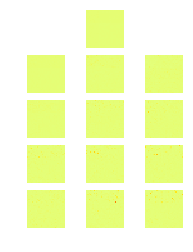

KeyboardInterrupt: 

In [27]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
            
        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if ct%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            global_step_log = sess.run(tf.train.get_global_step())
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topic
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)

# confirm variables

In [ ]:
debug_value([topic_embeddings[:, :5]])

In [43]:
_topic_bow, = debug_value([topic_bow], return_value=True)

<BarContainer object of 1035 artists>

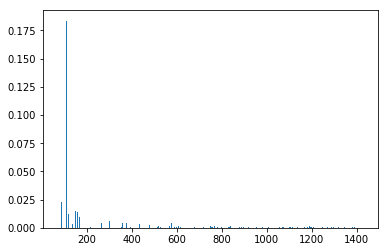

In [55]:
plt.bar(bow_idxs, topic_bow[0])

<BarContainer object of 1035 artists>

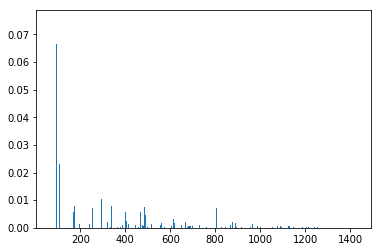

In [56]:
plt.bar(bow_idxs, topic_bow[1])

<BarContainer object of 1035 artists>

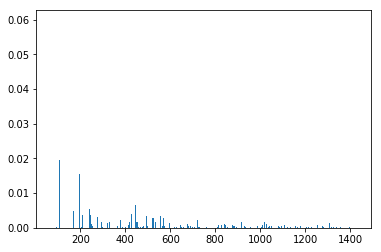

In [59]:
plt.bar(bow_idxs, topic_bow[2])

<BarContainer object of 1035 artists>

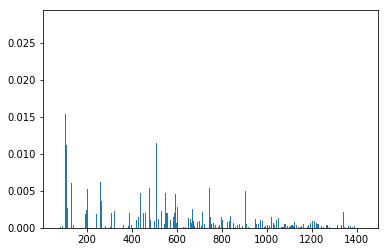

In [62]:
plt.bar(bow_idxs, topic_bow[4])

In [60]:
len(bow_idxs)

1035

In [39]:
debug_value([prob_topic[3]])

strided_slice_2:0 : [0.1489713  0.0706474  0.07743409 0.03776893 0.14249046 0.13351493
 0.18252574 0.168819   0.02399866 0.01382949]


In [ ]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

### test

In [12]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

Placeholder:0 : (32, 4022)
topic/enc/dropout/cond/Merge:0 : (32, 256)
topic/enc/add:0 : (32, 32)
topic/enc/prob/Softmax:0 : (32, 50)
embedding_lookup:0 : (4022, 256)
topic/dec/topic_emb:0 : (50, 256)
topic/dec/Softmax:0 : (50, 4022)
topic/dec/Log:0 : (32, 4022)


In [27]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

Sum:0 : (32,)
Neg:0 : ()
Sum_2:0 : (32,)
Neg_1:0 : (32,)
truediv_1:0 : (50, 256)
ExpandDims_1:0 : (1,)
Mean_3:0 : ()


In [14]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

array([1.        , 0.99999994, 0.9999999 , 1.        , 1.        ,
       1.0000001 , 0.9999999 , 1.0000001 , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 0.9999999 , 0.99999994, 1.        ,
       1.        , 0.9999999 , 1.0000001 , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 0.99999994,
       1.0000001 , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       0.9999999 , 1.        , 1.        , 1.        , 0.99999994,
       1.0000001 , 1.        , 1.        , 0.99999994, 1.        ],
      dtype=float32)

In [15]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

Sum_4:0 : [1.0000001  1.         1.0000001  0.99999994 1.         1.
 1.         0.99999994 0.99999994 1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9999999
 1.         0.99999994 1.         1.0000001  0.99999994 1.
 1.         1.        ]
Sum_5:0 : [1.         0.99999994 1.         0.99999994 0.99999994 1.
 1.         0.9999998  1.         1.         1.         1.
 1.         1.         1.         1.0000001  0.99999994 1.
 1.         0.99999994 0.9999999  0.99999994 1.0000001  1.
 1.         1.         1.         0.99999994 0.9999999  1.
 1.         1.         0.99999994 1.         0.99999994 1.
 1.         0.9999999  1.         1.         1.         1.
 0.99999994 1.         0.99999994 0.99999994 0.99999994 0.99999994
 1.         1.        ]
Sum_6:0 : [1.         1.         1.0000001  0.99999994 1.         1.
 0.9999999  0.99999994 0.9999999  1.         1.0000001  1.
 0.9999999  1.        

In [16]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [17]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

Neg:0 : 405.38312
Mean_1:0 : 0.32056683
Mean_4:0 : 0.32056683


In [110]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [111]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

((32, 32), (32, 32), (32,), (32, 32))

In [112]:
_output_logits

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [109]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


NameError: name 'dec_target_idxs_do' is not defined

In [44]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

(120, 46)

In [31]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

((120, 46, 20000), (120, 46), (120, 46))

In [32]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [33]:
_idxs = _dec_target_idxs_do

In [35]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [36]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

9.903732

In [37]:
_recon_loss

9.903732

In [38]:
_kl_losses.shape

(120,)